In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_base = pd.read_csv("Risk_Analysis.csv")
df_base.head()

,ConditionsSky,NumberStruckActual,WildlifeSize,AlertScore,Risk
0,No Cloud,859,Medium,1729,High
1,Some Cloud,424,Small,429,High
2,No Cloud,261,Small,263,High
3,Some Cloud,806,Small,811,High
4,No Cloud,942,Small,944,High


### EDA

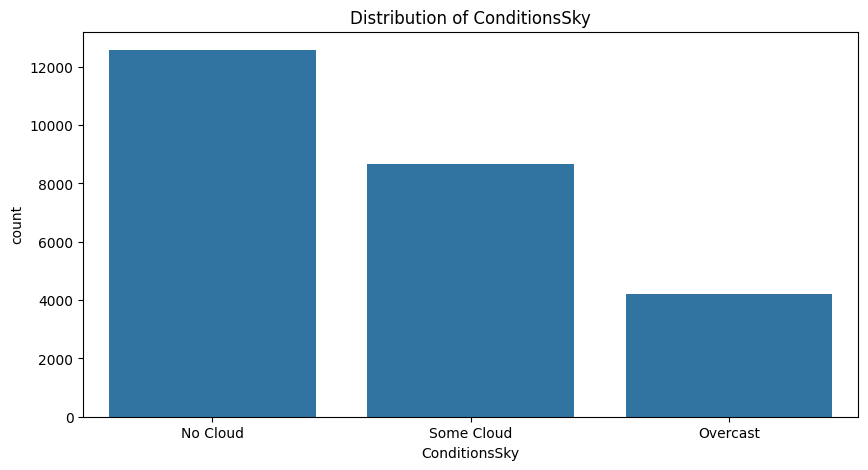

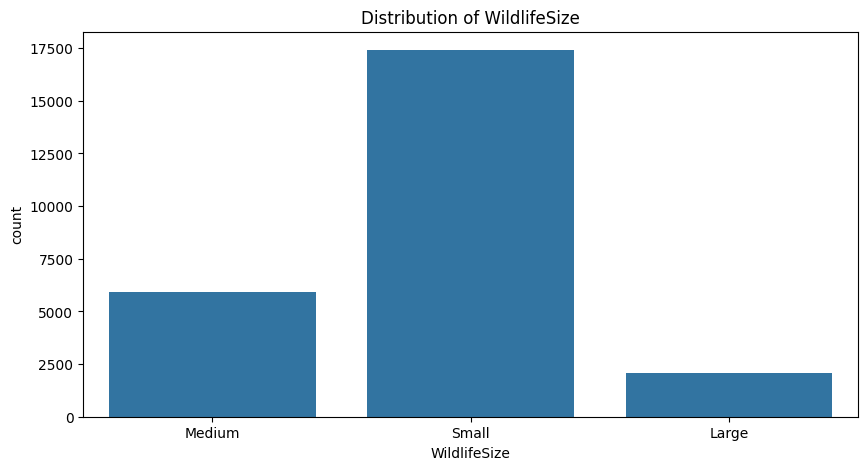

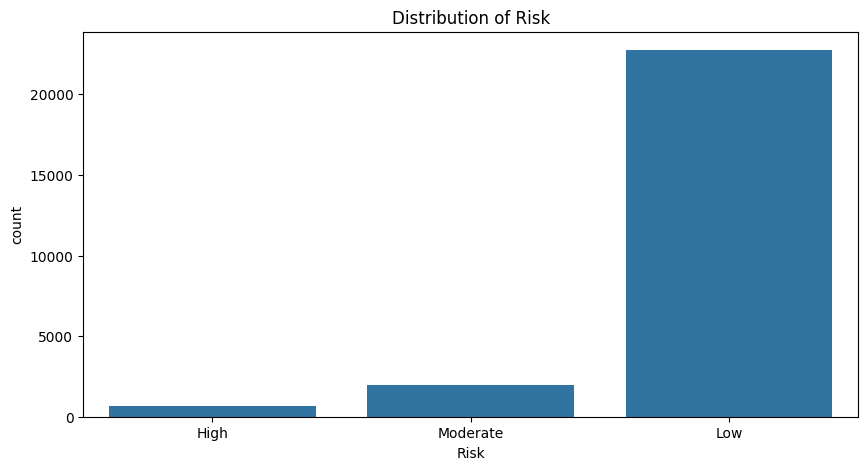

In [3]:
categorical_columns = ['ConditionsSky', 'WildlifeSize', 'Risk']

for column in categorical_columns:
    plt.figure(figsize=(10, 5))
    sns.countplot(data=df_base, x=column)
    plt.title(f'Distribution of {column}')
    plt.show()

In [4]:
df_base.drop("AlertScore", axis=1, inplace=True)

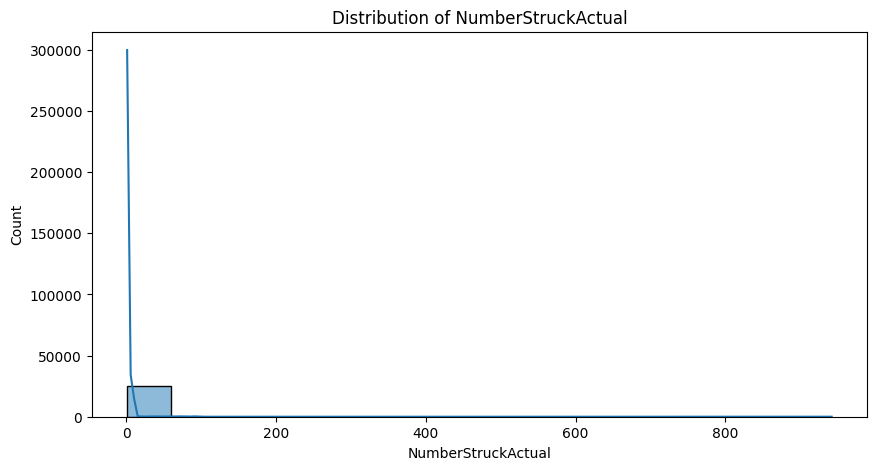

In [5]:
# plot the numerical numbers            
numerical_columns = ['NumberStruckActual']

for column in numerical_columns:
    plt.figure(figsize=(10, 5))
    sns.histplot(data=df_base, x=column, kde=True)
    plt.title(f'Distribution of {column}')
    plt.show()



In [6]:
from sklearn.preprocessing import OneHotEncoder

# Ordinal encoding for WildlifeSize and Risk
ordinal_mapping = {
    'WildlifeSize': {'Small': 0, 'Medium': 1, 'Large': 2},
    'Risk': {'Low': 0, 'Moderate': 1, 'High': 2}
}

df_ordinal = df_base.copy()
for column, mapping in ordinal_mapping.items():
    df_ordinal[column] = df_ordinal[column].map(mapping)

# One-hot encoding for ConditionsSky
one_hot_encoder = OneHotEncoder(sparse_output=False)
conditions_sky_encoded = one_hot_encoder.fit_transform(df_ordinal[['ConditionsSky']])
conditions_sky_encoded_df = pd.DataFrame(conditions_sky_encoded, columns=one_hot_encoder.get_feature_names_out(['ConditionsSky']))

# Combine the encoded columns with the rest of the dataframe
df_encoded = pd.concat([df_ordinal.drop('ConditionsSky', axis=1), conditions_sky_encoded_df], axis=1)

df_encoded.head()

,NumberStruckActual,WildlifeSize,Risk,ConditionsSky_No Cloud,ConditionsSky_Overcast,ConditionsSky_Some Cloud
0,859,1,2,1.0,0.0,0.0
1,424,0,2,0.0,0.0,1.0
2,261,0,2,1.0,0.0,0.0
3,806,0,2,0.0,0.0,1.0
4,942,0,2,1.0,0.0,0.0


In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from keras import Input

# Define the features (X) and target variable (y)
X = df_encoded.drop(columns=['Risk']) 
y = df_encoded['Risk']

#Ensure the target variable (y) is integer-encoded and then one-hot encode it
y = y.fillna(y.mode()[0])  # Fill missing values with the most frequent value
y_integer_encoded = y.astype(int)  # Ensure y is integer-encoded
y_encoded = to_categorical(y_integer_encoded, num_classes=3)  # 3 classes: 0 (Low), 1 (Moderate), 2 (High)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

y_train = np.argmax(y_train, axis=1)  # Convert back to labels
y_test = np.argmax(y_test, axis=1)
print(y_train[:5])  # Example output: [2 0 1 2 0]


# Step 4: Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



[0 0 2 0 0]


In [8]:
print("Class distribution in training data:", np.bincount(y_train))
print("Class distribution in test data:", np.bincount(y_test))

Class distribution in training data: [18198  1586   559]
Class distribution in test data: [4547  406  133]


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping

# Build the Neural Network
NN_model = Sequential([
    Input(shape=(X_train.shape[1],)),  # Define the input shape
    Dense(64, activation='relu'),      # First hidden layer
    Dense(32, activation='relu'),      # Second hidden layer
    Dense(16, activation='relu'),      # Third hidden layer
    Dense(3, activation='softmax')     # Output layer (3 classes)
])

# Compile the model
NN_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Set up early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',             # Monitor the validation loss
    patience=5,                     # Stop after 5 epochs with no improvement
    restore_best_weights=True       # Restore model weights from the best epoch
)

# Train the model with early stopping
NN_history = NN_model.fit(
    X_train, y_train, 
    epochs=50, 
    batch_size=32, 
    validation_split=0.2, 
    verbose=1, 
    callbacks=[early_stopping]
)

# Evaluate the model
loss, accuracy = NN_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")


Epoch 1/50
509/509 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8891 - loss: 0.4377 - val_accuracy: 0.9698 - val_loss: 0.1260
Epoch 2/50
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9634 - loss: 0.1346 - val_accuracy: 0.9698 - val_loss: 0.1074
Epoch 3/50
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9712 - loss: 0.1104 - val_accuracy: 0.9681 - val_loss: 0.1074
Epoch 4/50
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9681 - loss: 0.1163 - val_accuracy: 0.9744 - val_loss: 0.1018
Epoch 5/50
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9691 - loss: 0.1168 - val_accuracy: 0.9712 - val_loss: 0.1038
Epoch 6/50
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9718 - loss: 0.1077 - val_accuracy: 0.9737 - val_loss: 0.1011
Epoch 7/50
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9726 - loss: 0.1039 - val_accuracy: 0.9749 - val_loss: 0.0989
Epoch 8/50
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9725 - loss: 0.1108 - val_accuracy: 0.

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Classification Report:
              precision    recall  f1-score   support

         Low       0.98      1.00      0.99      4547
    Moderate       0.97      0.69      0.81       406
        High       0.89      0.95      0.92       133

    accuracy                           0.97      5086
   macro avg       0.94      0.88      0.90      5086
weighted avg       0.97      0.97      0.97      5086

Confusion Matrix:
[[4545    2    0]
 [ 108  282   16]
 [   0    7  126]]


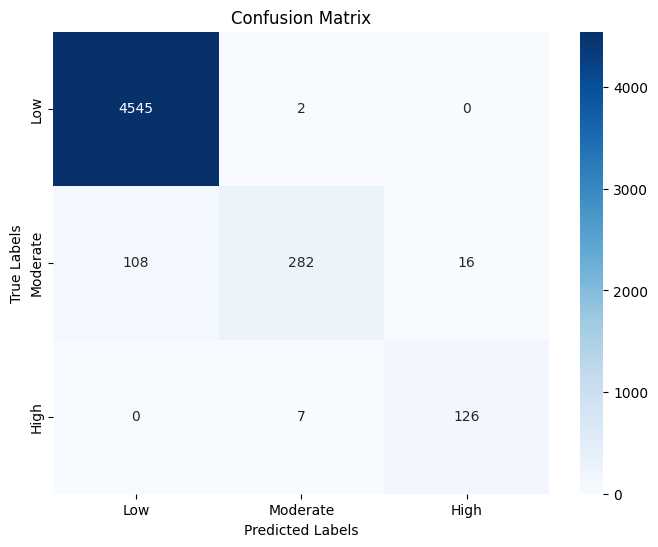

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Step 8: Evaluate the model and make predictions
y_pred = NN_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
y_test_classes = y_test

# Generate classification report
print("Classification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=['Low', 'Moderate', 'High'], labels=[0, 1, 2]))

# Generate confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
print("Confusion Matrix:")
print(cm)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'Moderate', 'High'], yticklabels=['Low', 'Moderate', 'High'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [11]:
from sklearn.model_selection import KFold
import numpy as np
from tensorflow.keras.models import load_model

# Set up KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation

# Store cross-validation results
cv_loss = []
cv_accuracy = []

# KFold cross-validation
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Evaluate the pre-trained model on the validation fold
    val_loss, val_accuracy = NN_model.evaluate(X_val_fold, y_val_fold, verbose=0)
    
    # Store results for each fold
    cv_loss.append(val_loss)
    cv_accuracy.append(val_accuracy)

# Print cross-validation results
print(f"Mean Cross-Validation Loss: {np.mean(cv_loss):.4f}")
print(f"Mean Cross-Validation Accuracy: {np.mean(cv_accuracy):.4f}")


Mean Cross-Validation Loss: 0.0991
Mean Cross-Validation Accuracy: 0.9738


In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


Training Accuracy: 0.9752
Test Accuracy: 0.9748
Confusion Matrix:
[[4545    2    0]
 [ 108  297    1]
 [   0   17  116]]
Classification Report:
              precision    recall  f1-score   support

         Low       0.98      1.00      0.99      4547
    Moderate       0.94      0.73      0.82       406
        High       0.99      0.87      0.93       133

    accuracy                           0.97      5086
   macro avg       0.97      0.87      0.91      5086
weighted avg       0.97      0.97      0.97      5086



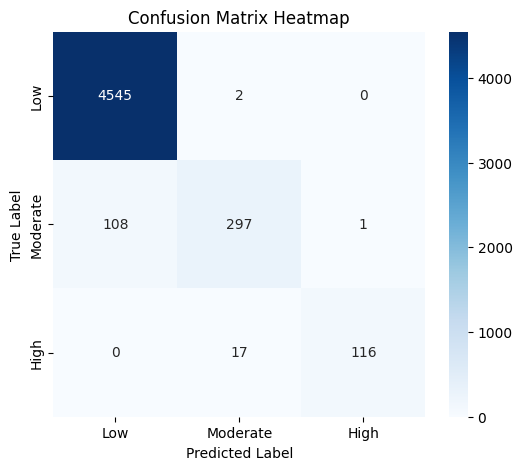

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np

# Initialize the Random Forest model
RF_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the Random Forest model
RF_model.fit(X_train, y_train)

y_train_pred = RF_model.predict(X_train)

# Calculate training accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)

print(f"Training Accuracy: {train_accuracy:.4f}")

# Predict on test data
y_pred = RF_model.predict(X_test)


# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Generate a classification report
class_report = classification_report(y_test, y_pred, target_names=['Low', 'Moderate', 'High'])
print("Classification Report:")
print(class_report)

class_labels = ['Low', 'Moderate', 'High']  # Adjust based on your risk labels

# Plot the heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Heatmap")
plt.show()


Cross-validation Accuracy: 0.9745 ± 0.0009
Cross-Validation Confusion Matrix:
[[18197     1     0]
 [  431  1135    20]
 [    0    67   492]]


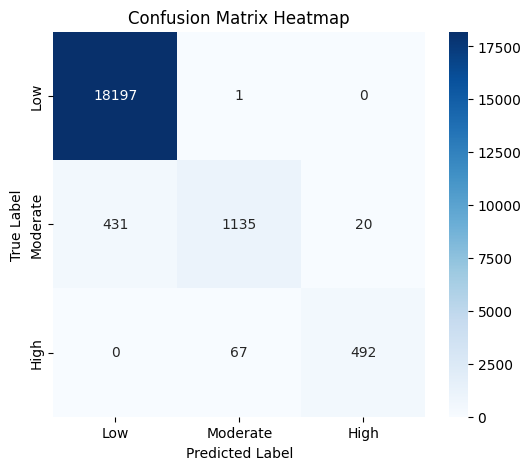

In [14]:
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import numpy as np

# Perform cross-validation (5-fold)
cv_scores = cross_val_score(RF_model, X_train, y_train, cv=5, scoring='accuracy')

# Calculate the mean and standard deviation of cross-validation results
mean_cv_accuracy = np.mean(cv_scores)
std_cv_accuracy = np.std(cv_scores)

print(f"Cross-validation Accuracy: {mean_cv_accuracy:.4f} ± {std_cv_accuracy:.4f}")

# Get cross-validation predictions
y_pred_cv = cross_val_predict(RF_model, X_train, y_train, cv=5)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_train, y_pred_cv)

print("Cross-Validation Confusion Matrix:")
print(conf_matrix)

class_labels = ['Low', 'Moderate', 'High']  # Adjust based on your risk labels

# Plot the heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Heatmap")
plt.show()


159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


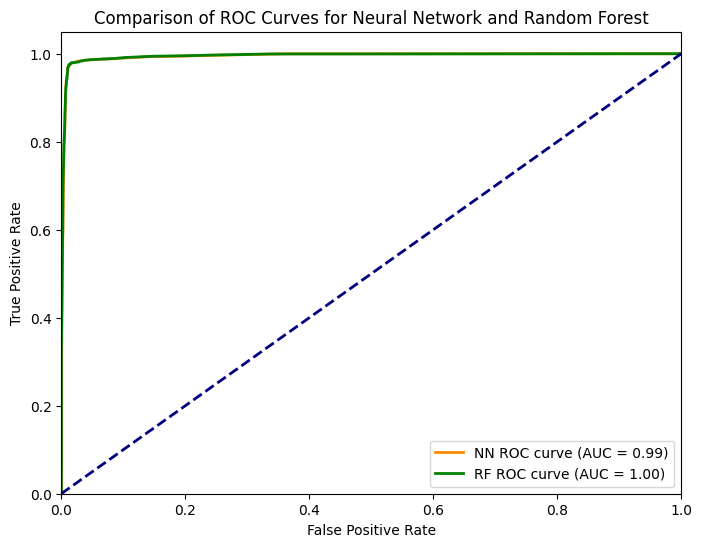

Neural Network AUC: 0.9949
Random Forest AUC: 0.9950


In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import RocCurveDisplay

# Binarize the labels for multi-class classification (assuming 3 classes)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])  # Modify if you have different class labels

# 1. Neural Network ROC Curve
y_pred_nn = NN_model.predict(X_test)

# Compute ROC curve and AUC for the Neural Network model
fpr_nn, tpr_nn, thresholds_nn = roc_curve(y_test_bin.ravel(), y_pred_nn.ravel())
roc_auc_nn = auc(fpr_nn, tpr_nn)

# 2. Random Forest ROC Curve
y_pred_rf = RF_model.predict_proba(X_test)

# Compute ROC curve and AUC for the Random Forest model
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test_bin.ravel(), y_pred_rf.ravel())
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plotting the ROC curves for both models
plt.figure(figsize=(8, 6))

# ROC curve for Neural Network
plt.plot(fpr_nn, tpr_nn, color='darkorange', lw=2, label=f'NN ROC curve (AUC = {roc_auc_nn:.2f})')

# ROC curve for Random Forest
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label=f'RF ROC curve (AUC = {roc_auc_rf:.2f})')

# Random guessing line (diagonal)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Labels and title
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparison of ROC Curves for Neural Network and Random Forest')
plt.legend(loc="lower right")

# Show the plot
plt.show()

# Print AUC values for comparison
print(f"Neural Network AUC: {roc_auc_nn:.4f}")
print(f"Random Forest AUC: {roc_auc_rf:.4f}")


In [16]:
feature_order = X.columns
print("Feature order:", feature_order)

Feature order: Index(['NumberStruckActual', 'WildlifeSize', 'ConditionsSky_No Cloud',
       'ConditionsSky_Overcast', 'ConditionsSky_Some Cloud'],
      dtype='object')


In [17]:
from joblib import dump
dump(RF_model, 'random_forest_model.joblib')
print("Model saved as 'random_forest_model.joblib'")

Model saved as 'random_forest_model.joblib'
